# **Import libraries**

In [40]:
import pandas as pd
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer
from pyspark.ml import Pipeline
import joblib

In [5]:
spark = SparkSession.builder.appName("OpenFoodFactsEDA").getOrCreate()
df = spark.read.option("header", "true").option("inferSchema", "true").csv("cleaned_data.csv")
df.printSchema()


root
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- countries_en: string (nullable = true)
 |-- ingredients_text: string (nullable = true)
 |-- allergens: string (nullable = true)
 |-- nutriscore_grade: string (nullable = true)
 |-- nutriscore_score: string (nullable = true)
 |-- nova_group: string (nullable = true)
 |-- nutrition-score-fr_100g: string (nullable = true)
 |-- energy-kcal_100g: string (nullable = true)
 |-- fat_100g: string (nullable = true)
 |-- saturated-fat_100g: string (nullable = true)
 |-- carbohydrates_100g: string (nullable = true)
 |-- sugars_100g: string (nullable = true)
 |-- fiber_100g: string (nullable = true)
 |-- proteins_100g: string (nullable = true)
 |-- salt_100g: string (nullable = true)
 |-- sodium_100g: string (nullable = true)



**OpennFoodDataClenear :
For some data cleaning**

In [6]:
class OpenFoodDataCleaner:
    def __init__(self, spark_session):
        self.spark = spark_session

    def select_key_columns(self, df):

        # Define key columns  that we're intersted with
        key_columns = [
            'product_name',
            'brands',
            'categories',
            'ingredients_text',
            'allergens',
            'nutriscore_grade',
            'nutrition-score-fr_100g',
            'energy-kcal_100g',
            'carbohydrates_100g',
            'sugars_100g',
            'proteins_100g',
        ]

        # Select available columns
        available_cols = []
        for col_name in key_columns:
            if col_name in df.columns:
                available_cols.append(col(col_name))
            else:
                print(f" Column '{col_name}' not found in dataset")

        if available_cols:
            cleaned_df = df.select(*available_cols)
            print(f"Selected {len(available_cols)} columns")
            return cleaned_df
        else:
            print("No columns found!")
            return df

    def clean_data_types(self, df):
        print("Cleaning data types...")


        cleaned_df = df

        # Nutritional columns to convert to double type
        nutritional_cols = [
            "energy-kcal_100g", "fat_100g", "saturated-fat_100g",
            "carbohydrates_100g", "sugars_100g", "fiber_100g",
            "proteins_100g", "salt_100g", "sodium_100g"
        ]

        # Convert nutritional columns and fill nulls with 0
        for col_name in nutritional_cols:
            if col_name in cleaned_df.columns:
                cleaned_df = cleaned_df.withColumn(
                    col_name,
                    coalesce(col(col_name).cast("double"), lit(0.0))
                )

        # Fill categorical nulls
        fill_values = {}
        if "brands" in cleaned_df.columns:
            fill_values["brands"] = "unknown"
        if "categories" in cleaned_df.columns:
            fill_values["categories"] = "unknown"
        if "ingredients_text" in cleaned_df.columns:
            fill_values["ingredients_text"] = ""
        if "allergens" in cleaned_df.columns:
            fill_values["allergens"] = ""
        if "nutriscore_grade" in cleaned_df.columns:
            fill_values["nutriscore_grade"] = "unknown"

        cleaned_df = cleaned_df.fillna(fill_values)

        # Add derived features
        if "nutriscore_grade" in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                "has_nutriscore",
                when(col("nutriscore_grade").isin(["A", "B", "C", "D", "E"]), 1).otherwise(0)
            )

        if "brands" in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                "brand_count",
                size(split(col("brands"), ","))
            )


        count = cleaned_df.count()
        print(f"Cleaned dataset size: {count:,}")

        return cleaned_df

    def filter_french_products(self, df):
        # Check which country columns exist
        country_conditions = []

        if "countries_en" in df.columns:
            country_conditions.append(col("countries_en").contains("France"))
            country_conditions.append(col("countries_en").contains("france"))

        if country_conditions:
            # Combine conditions with OR
            french_condition = country_conditions[0]
            for condition in country_conditions[1:]:
                french_condition = french_condition | condition

            french_df = df.filter(french_condition)
        else:
            print(" No country columns found, using all products")
            french_df = df

        # Filter out products with missing essential data
        french_df = french_df.filter(
            col("product_name").isNotNull() &
            (col("product_name") != "")
        )

        count = french_df.count()
        print(f"Found {count:,} French products")

        # If no French products found, take a sample for demo
        if count == 0:
            print("No French products found. Taking sample for demo...")
            french_df = df.filter(
                col("product_name").isNotNull() &
                (col("product_name") != "")
            ).sample(0.05, seed=42)
            count = french_df.count()
            print(f"Sample size: {count:,} products")

        return french_df


    def process_data(self, df):
        print("Starting data processing pipeline...")

        french_df = self.filter_french_products(df)

        selected_df = self.select_key_columns(french_df)

        cleaned_df = self.clean_data_types(selected_df)

        print("Data processing pipeline completed!")
        return cleaned_df


**Execute the Clenear on our df**

In [7]:
cleaner = OpenFoodDataCleaner(spark)
french_df = spark.read.option("header", "true").option("inferSchema", "true").csv("cleaned_data.csv")
processed_df = cleaner.process_data(french_df)
# see some output
processed_df.cache()
processed_df.show(5, truncate=False)


Starting data processing pipeline...
 Found 163,294 French products
Selected 11 columns
Cleaning data types...
Cleaned dataset size: 163,294
Data processing pipeline completed!
+------------------------------------------------------------+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# processed_df.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = false)
 |-- categories: string (nullable = false)
 |-- ingredients_text: string (nullable = false)
 |-- allergens: string (nullable = false)
 |-- nutriscore_grade: string (nullable = false)
 |-- nutrition-score-fr_100g: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = false)
 |-- carbohydrates_100g: double (nullable = false)
 |-- sugars_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)
 |-- has_nutriscore: integer (nullable = false)
 |-- brand_count: integer (nullable = false)



In [8]:
def create_simple_health_score(df):
    print("Creating simple health score...")

    df = df.withColumn(
        "health_score",
        (
            # Protein
            when(col("proteins_100g") >= 20, 3.0)
            .when(col("proteins_100g") >= 10, 2.0)
            .when(col("proteins_100g") >= 5, 1.0)
            .otherwise(0.0) +

            # Sugar penalty (0-3 points)
            when(col("sugars_100g") <= 5, 3.0)
            .when(col("sugars_100g") <= 10, 2.0)
            .when(col("sugars_100g") <= 20, 1.0)
            .otherwise(0.0) +

            # Calorie density (0-2 points)
            when(col("energy-kcal_100g") <= 200, 2.0)
            .when(col("energy-kcal_100g") <= 400, 1.0)
            .otherwise(0.0) +

            # Nutri-score
            when(lower(col("nutriscore_grade")) == "A", 2.0)
            .when(lower(col("nutriscore_grade")) == "B", 1.5)
            .when(lower(col("nutriscore_grade")) == "C", 1.0)
            .when(lower(col("nutriscore_grade")) == "D", 0.5)
            .otherwise(0.0)
        )
    )

    # Simple health categories
    df = df.withColumn(
        "health_category",
        when(col("health_score") >= 8, "Excellent")
        .when(col("health_score") >= 6, "Good")
        .when(col("health_score") >= 4, "Average")
        .when(col("health_score") >= 2, "Poor")
        .otherwise("Very Poor")
    )

    print("Simple health score created!")
    return df

In [9]:

# Initialize and run
final_df = create_simple_health_score(processed_df)

Creating simple health score...
Simple health score created!


**function to create some healthy column to make oue systen more strong like free gluten lower suger**

In [18]:
from pyspark.sql.types import BooleanType, StringType
from typing import List, Dict, Optional
from pyspark.sql.functions import col, when, lit, concat_ws, size, split, coalesce, avg, count, sum
from pyspark.sql import DataFrame # Import DataFrame if not already global

def create_health_column(df: DataFrame) -> DataFrame:
    # Create gluten-free check
    gluten_free_condition = (
        ~(lower(col("ingredients_text")).contains("gluten") |
          lower(col("ingredients_text")).contains("wheat") |
          lower(col("ingredients_text")).contains("barley") |
          lower(col("ingredients_text")).contains("rye") |
          lower(col("ingredients_text")).contains("oats") |
          lower(col("ingredients_text")).contains("spelt")) &
        ~(lower(col("allergens")).contains("gluten") |
          lower(col("allergens")).contains("wheat") |
          lower(col("allergens")).contains("barley") |
          lower(col("allergens")).contains("rye") |
          lower(col("allergens")).contains("oats") |
          lower(col("allergens")).contains("spelt"))
    )

    # Add health-conscious columns
    df_with_health = df.withColumn(
        "is_gluten_free",
        when(gluten_free_condition, True).otherwise(False)
    ).withColumn(
        "is_low_sugar",
        when(col("sugars_100g") < 5.0, True).otherwise(False)
    ).withColumn(
        "is_high_protein",
        when(col("proteins_100g") > 10.0, True).otherwise(False)
    ).withColumn(
        "is_low_calorie",
        when(col("energy-kcal_100g") < 200, True).otherwise(False)
    )

    # Create allergen-friendly flags
    df_with_health = df_with_health.withColumn(
        "is_dairy_free",
        when(
            ~(lower(col("allergens")).contains("milk") |
              lower(col("allergens")).contains("lactose") |
              lower(col("allergens")).contains("casein") |
              lower(col("allergens")).contains("whey")),
            True
        ).otherwise(False)
    ).withColumn(
        "is_nut_free",
        when(
            ~(lower(col("allergens")).contains("nuts") |
              lower(col("allergens")).contains("peanuts") |
              lower(col("allergens")).contains("almonds") |
              lower(col("allergens")).contains("walnuts")),
            True
        ).otherwise(False)
    ).withColumn(
        "is_soy_free",
        when(
            ~(lower(col("allergens")).contains("soy") |
              lower(col("allergens")).contains("soja")),
            True
        ).otherwise(False)
    ).withColumn(
        "is_egg_free",
        when(
            ~(lower(col("allergens")).contains("eggs") |
              lower(col("allergens")).contains("egg")),
            True
        ).otherwise(False)
    )

    # Create combined health flags
    health_flags_array = []

    df_with_health = df_with_health.withColumn(
        "health_flags",
        concat_ws(",",
            when(col("is_gluten_free"), lit("gluten_free")),
            when(col("is_low_sugar"), lit("low_sugar")),
            when(col("is_high_protein"), lit("high_protein")),
            when(col("is_low_calorie"), lit("low_calorie"))
        )
    ).withColumn(
        "allergen_friendly",
        concat_ws(",",
            when(col("is_dairy_free"), lit("dairy_free")),
            when(col("is_nut_free"), lit("nut_free")),
            when(col("is_soy_free"), lit("soy_free")),
            when(col("is_egg_free"), lit("egg_free"))
        )
    )

    return df_with_health

def filter_health_products(df: DataFrame,
                          gluten_free: bool = False,
                          low_sugar: bool = False,
                          high_protein: bool = False,
                          low_calorie: bool = False,
                          min_health_score: Optional[float] = None,
                          max_calories: Optional[float] = None,
                          dairy_free: bool = False,
                          nut_free: bool = False,
                          soy_free: bool = False,
                          egg_free: bool = False) -> DataFrame:
    filtered_df = df

    if gluten_free:
        filtered_df = filtered_df.filter(col("is_gluten_free") == True)

    if low_sugar:
        filtered_df = filtered_df.filter(col("is_low_sugar") == True)

    if high_protein:
        filtered_df = filtered_df.filter(col("is_high_protein") == True)

    if low_calorie:
        filtered_df = filtered_df.filter(col("is_low_calorie") == True)

    if min_health_score is not None:
        filtered_df = filtered_df.filter(col("health_score") >= min_health_score)

    if max_calories is not None:
        filtered_df = filtered_df.filter(col("energy-kcal_100g") <= max_calories)

    if dairy_free:
        filtered_df = filtered_df.filter(col("is_dairy_free") == True)

    if nut_free:
        filtered_df = filtered_df.filter(col("is_nut_free") == True)

    if soy_free:
        filtered_df = filtered_df.filter(col("is_soy_free") == True)

    if egg_free:
        filtered_df = filtered_df.filter(col("is_egg_free") == True)

    return filtered_df

def get_health_summary(df: DataFrame) -> Dict:

    # Calculate summary statistics
    summary_stats = df.agg(
        count("*").alias("total_products"),
        sum(when(col("is_gluten_free"), 1).otherwise(0)).alias("gluten_free_count"), # Changed spark_sum to sum
        sum(when(col("is_low_sugar"), 1).otherwise(0)).alias("low_sugar_count"),       # Changed spark_sum to sum
        sum(when(col("is_high_protein"), 1).otherwise(0)).alias("high_protein_count"), # Changed spark_sum to sum
        sum(when(col("is_low_calorie"), 1).otherwise(0)).alias("low_calorie_count"),   # Changed spark_sum to sum
        avg("health_score").alias("avg_health_score"),
        avg("energy-kcal_100g").alias("avg_calories")
    ).collect()[0]

    total_products = summary_stats["total_products"]

    summary = {
        'total_products': total_products,
        'gluten_free_count': summary_stats["gluten_free_count"],
        'low_sugar_count': summary_stats["low_sugar_count"],
        'high_protein_count': summary_stats["high_protein_count"],
        'low_calorie_count': summary_stats["low_calorie_count"],
        'gluten_free_percentage': (summary_stats["gluten_free_count"] / total_products * 100) if total_products > 0 else 0,
        'average_health_score': summary_stats["avg_health_score"],
        'average_calories': summary_stats["avg_calories"]
    }

    return summary

def show_health_products_sample(df: DataFrame, n: int = 10):
    df.select(
        "product_name",
        "brands",
        "health_flags",
        "allergen_friendly",
        "health_score",
        "energy-kcal_100g",
        "sugars_100g",
        "proteins_100g"
    ).show(n, truncate=False)

**Applied our function on our cleaned dataframe**

In [20]:
 final_df = create_health_column(final_df)

# Filter for gluten-free, low sugar products exemple
healthy_products = filter_health_products(
    final_df,
    gluten_free=True,
    low_sugar=True,
    min_health_score=7.0,
    max_calories=200,
    dairy_free=True
)

# Get summary
summary = get_health_summary(final_df)
print(summary)

print(f"Total healthy products: {healthy_products.count()}")
show_health_products_sample(healthy_products, 10)


{'total_products': 163294, 'gluten_free_count': 119221, 'low_sugar_count': 91882, 'high_protein_count': 46511, 'low_calorie_count': 66968, 'gluten_free_percentage': 73.01003098705402, 'average_health_score': 4.157574681249771, 'average_calories': 274.3715439296806}
Total healthy products: 10433
+-------------------------------------------------------------+------------------------+----------------------------------------------+-------------------------------------+------------+----------------+-----------+-------------+
|product_name                                                 |brands                  |health_flags                                  |allergen_friendly                    |health_score|energy-kcal_100g|sugars_100g|proteins_100g|
+-------------------------------------------------------------+------------------------+----------------------------------------------+-------------------------------------+------------+----------------+-----------+-------------+
|1 Faux Filet*

In [21]:
final_df.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- brands: string (nullable = false)
 |-- categories: string (nullable = false)
 |-- ingredients_text: string (nullable = false)
 |-- allergens: string (nullable = false)
 |-- nutriscore_grade: string (nullable = false)
 |-- nutrition-score-fr_100g: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = false)
 |-- carbohydrates_100g: double (nullable = false)
 |-- sugars_100g: double (nullable = false)
 |-- proteins_100g: double (nullable = false)
 |-- has_nutriscore: integer (nullable = false)
 |-- brand_count: integer (nullable = false)
 |-- health_score: double (nullable = false)
 |-- health_category: string (nullable = false)
 |-- is_gluten_free: boolean (nullable = false)
 |-- is_low_sugar: boolean (nullable = false)
 |-- is_high_protein: boolean (nullable = false)
 |-- is_low_calorie: boolean (nullable = false)
 |-- is_dairy_free: boolean (nullable = false)
 |-- is_nut_free: boolean (nullable = false)
 |-- is_soy_fre


# **VISUALISATION**
**make some visualisation to  understand the architecture of pour dataframe to well build our recommender**


In [37]:
import numpy as np
import builtins

class HealthScoreAnalyzer:
    def __init__(self, spark_session):
        self.spark = spark_session
        plt.style.use('default')
        sns.set_palette("husl")

    def _spark_to_pandas(self, spark_df, limit=None):

        if limit:
            return spark_df.limit(limit).toPandas()
        return spark_df.toPandas()

    def analyze_health_distribution(self, df, show_plots=True):

        print("📊 HEALTH SCORE DISTRIBUTION")
        print("=" * 50)

        # Basic stats
        health_stats = df.select(
            round(avg("health_score"), 2).alias("avg_score"),
            round(stddev("health_score"), 2).alias("std_score"),
            min("health_score").alias("min_score"),
            max("health_score").alias("max_score"),
            count("*").alias("total_products")
        ).collect()[0]

        print(f"Average Health Score: {health_stats['avg_score']}/10")
        print(f"Standard Deviation: {health_stats['std_score']}")
        print(f"Score Range: {health_stats['min_score']} - {health_stats['max_score']}")
        print(f"Total Products: {health_stats['total_products']:,}")
        print()

        if show_plots:
            # Get data for plotting
            health_data = self._spark_to_pandas(df.select("health_score", "health_category"))

            # Create subplots
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Health Score Distribution Analysis', fontsize=16, fontweight='bold')

            # 1. Health Score Histogram
            axes[0,0].hist(health_data['health_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0,0].axvline(health_data['health_score'].mean(), color='red', linestyle='--',
                             label=f'Mean: {health_data["health_score"].mean():.2f}')
            axes[0,0].set_xlabel('Health Score')
            axes[0,0].set_ylabel('Number of Products')
            axes[0,0].set_title('Health Score Distribution')
            axes[0,0].legend()
            axes[0,0].grid(True, alpha=0.3)

            # 2. Health Category Pie Chart
            category_counts = health_data['health_category'].value_counts()
            colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
            axes[0,1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
                         colors=colors[:len(category_counts)])
            axes[0,1].set_title('Health Category Distribution')

            # 3. Box Plot by Category
            category_order = ['Excellent', 'Good', 'Average', 'Poor', 'Very Poor']
            existing_categories = [cat for cat in category_order if cat in health_data['health_category'].unique()]

            box_data = [health_data[health_data['health_category'] == cat]['health_score']
                       for cat in existing_categories]
            axes[1,0].boxplot(box_data, labels=existing_categories)
            axes[1,0].set_xlabel('Health Category')
            axes[1,0].set_ylabel('Health Score')
            axes[1,0].set_title('Health Score Distribution by Category')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].grid(True, alpha=0.3)

            # 4. Cumulative Distribution
            sorted_scores = np.sort(health_data['health_score'])
            cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
            axes[1,1].plot(sorted_scores, cumulative, linewidth=2, color='purple')
            axes[1,1].set_xlabel('Health Score')
            axes[1,1].set_ylabel('Cumulative Percentage')
            axes[1,1].set_title('Cumulative Health Score Distribution')
            axes[1,1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        # Category distribution table
        print("Health Category Breakdown:")
        df.groupBy("health_category").agg(
            count("*").alias("count"),
            round((count("*") / health_stats['total_products'] * 100), 1).alias("percentage"),
            round(avg("health_score"), 2).alias("avg_score")
        ).orderBy(col("avg_score").desc()).show()

        return health_stats

    def analyze_by_category(self, df, show_plots=True):
        print("\n🍎 HEALTH BY FOOD CATEGORY")
        print("=" * 50)

        # Extract main category
        df_with_category = df.withColumn(
            "main_category",
            when(lower(col("categories")).contains("dairy"), "Dairy")
            .when(lower(col("categories")).contains("meat"), "Meat")
            .when(lower(col("categories")).contains("fruit"), "Fruits")
            .when(lower(col("categories")).contains("vegetable"), "Vegetables")
            .when(lower(col("categories")).contains("cereal"), "Cereals")
            .when(lower(col("categories")).contains("beverage"), "Beverages")
            .when(lower(col("categories")).contains("snack"), "Snacks")
            .otherwise("Other")
        )

        category_analysis = df_with_category.groupBy("main_category").agg(
            count("*").alias("product_count"),
            round(avg("health_score"), 2).alias("avg_health_score"),
            round(avg("proteins_100g"), 1).alias("avg_protein"),
            round(avg("sugars_100g"), 1).alias("avg_sugar"),
            round(avg("energy-kcal_100g"), 0).alias("avg_calories")
        ).orderBy(col("avg_health_score").desc())

        if show_plots:
            # Get data for plotting
            category_data = self._spark_to_pandas(category_analysis)
            detail_data = self._spark_to_pandas(df_with_category.select("main_category", "health_score"))

            # Create plots
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Health Analysis by Food Category', fontsize=16, fontweight='bold')

            # 1. Average Health Score by Category
            bars = axes[0,0].bar(category_data['main_category'], category_data['avg_health_score'],
                                color='lightcoral', alpha=0.8)
            axes[0,0].set_ylabel('Average Health Score')
            axes[0,0].set_title('Average Health Score by Category')
            axes[0,0].tick_params(axis='x', rotation=45)
            axes[0,0].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                              f'{height:.1f}', ha='center', va='bottom')

            # 2. Product Count by Category
            axes[0,1].bar(category_data['main_category'], category_data['product_count'],
                         color='lightblue', alpha=0.8)
            axes[0,1].set_ylabel('Number of Products')
            axes[0,1].set_title('Product Count by Category')
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # 3. Health Score Distribution by Category (Violin Plot)
            categories = detail_data['main_category'].unique()
            violin_data = [detail_data[detail_data['main_category'] == cat]['health_score']
                          for cat in categories]

            parts = axes[1,0].violinplot(violin_data, positions=range(len(categories)), showmeans=True)
            axes[1,0].set_xticks(range(len(categories)))
            axes[1,0].set_xticklabels(categories, rotation=45)
            axes[1,0].set_ylabel('Health Score')
            axes[1,0].set_title('Health Score Distribution by Category')
            axes[1,0].grid(True, alpha=0.3)
        print("Category Health Rankings:")
        category_analysis.show(truncate=False)

        return category_analysis

    def analyze_score_components(self, df, show_plots=True):
        print("\n🔍 HEALTH SCORE COMPONENTS ANALYSIS")
        print("=" * 50)

        # Calculate components
        df_components = df.withColumn(
            "protein_points",
            when(col("proteins_100g") >= 20, 3.0)
            .when(col("proteins_100g") >= 10, 2.0)
            .when(col("proteins_100g") >= 5, 1.0)
            .otherwise(0.0)
        ).withColumn(
            "sugar_points",
            when(col("sugars_100g") <= 5, 3.0)
            .when(col("sugars_100g") <= 10, 2.0)
            .when(col("sugars_100g") <= 20, 1.0)
            .otherwise(0.0)
        ).withColumn(
            "calorie_points",
            when(col("energy-kcal_100g") <= 200, 2.0)
            .when(col("energy-kcal_100g") <= 400, 1.0)
            .otherwise(0.0)
        ).withColumn(
            "nutriscore_points",
            when(lower(col("nutriscore_grade")) == "A", 2.0)
            .when(lower(col("nutriscore_grade")) == "B", 1.5)
            .when(lower(col("nutriscore_grade")) == "C", 1.0)
            .when(lower(col("nutriscore_grade")) == "D", 0.5)
            .otherwise(0.0)
        )

        component_stats = df_components.select(
            round(avg("protein_points"), 2).alias("avg_protein_points"),
            round(avg("sugar_points"), 2).alias("avg_sugar_points"),
            round(avg("calorie_points"), 2).alias("avg_calorie_points"),
            round(avg("nutriscore_points"), 2).alias("avg_nutriscore_points")
        ).collect()[0]

        if show_plots:
            # Get component data
            component_data = self._spark_to_pandas(
                df_components.select("protein_points", "sugar_points", "calorie_points",
                                   "nutriscore_points", "health_score", "proteins_100g",
                                   "sugars_100g", "energy-kcal_100g")
            )

            # Create plots
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Health Score Components Analysis', fontsize=16, fontweight='bold')

            # 1. Component Contribution Bar Chart
            components = ['Protein\n(max 3)', 'Sugar\n(max 3)', 'Calorie\n(max 2)', 'NutriScore\n(max 2)']
            values = [component_stats['avg_protein_points'], component_stats['avg_sugar_points'],
                     component_stats['avg_calorie_points'], component_stats['avg_nutriscore_points']]
            max_values = [3, 3, 2, 2]

            x_pos = np.arange(len(components))
            bars = axes[0,0].bar(x_pos, values, color=['lightgreen', 'lightcoral', 'lightsalmon', 'lightblue'])

            # Add max value reference lines
            for i, max_val in enumerate(max_values):
                axes[0,0].axhline(y=max_val, xmin=i/len(components), xmax=(i+1)/len(components),
                                 color='red', linestyle='--', alpha=0.7)

            axes[0,0].set_ylabel('Average Points')
            axes[0,0].set_title('Average Component Scores')
            axes[0,0].set_xticks(x_pos)
            axes[0,0].set_xticklabels(components)
            axes[0,0].grid(True, alpha=0.3)

            # Add value labels
            for bar, val in zip(bars, values):
                axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                              f'{val:.2f}', ha='center', va='bottom')

            # 2. Component Distribution Stacked Bar
            component_cols = ['protein_points', 'sugar_points', 'calorie_points', 'nutriscore_points']
            stacked_data = component_data[component_cols].mean()

            axes[0,1].bar(range(len(stacked_data)), stacked_data.values,
                         color=['lightgreen', 'lightcoral', 'lightsalmon', 'lightblue'])
            axes[0,1].set_ylabel('Average Points Contribution')
            axes[0,1].set_title('Component Contribution to Health Score')
            axes[0,1].set_xticks(range(len(stacked_data)))
            axes[0,1].set_xticklabels(['Protein', 'Sugar', 'Calorie', 'NutriScore'], rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # 3. Scatter plot: Protein vs Health Score
            axes[1,0].scatter(component_data['proteins_100g'], component_data['health_score'],
                             alpha=0.6, color='green')
            axes[1,0].set_xlabel('Protein (g/100g)')
            axes[1,0].set_ylabel('Health Score')
            axes[1,0].set_title('Health Score vs Protein Content')
            axes[1,0].grid(True, alpha=0.3)

            # Add trend line
            z = np.polyfit(component_data['proteins_100g'], component_data['health_score'], 1)
            p = np.poly1d(z)
            axes[1,0].plot(component_data['proteins_100g'], p(component_data['proteins_100g']),
                          "r--", alpha=0.8)

            # 4. Scatter plot: Sugar vs Health Score
            axes[1,1].scatter(component_data['sugars_100g'], component_data['health_score'],
                             alpha=0.6, color='red')
            axes[1,1].set_xlabel('Sugar (g/100g)')
            axes[1,1].set_ylabel('Health Score')
            axes[1,1].set_title('Health Score vs Sugar Content')
            axes[1,1].grid(True, alpha=0.3)

            # Add trend line
            z = np.polyfit(component_data['sugars_100g'], component_data['health_score'], 1)
            p = np.poly1d(z)
            axes[1,1].plot(component_data['sugars_100g'], p(component_data['sugars_100g']),
                          "r--", alpha=0.8)

            plt.tight_layout()
            plt.show()

        print("Average Points by Component (out of max possible):")
        print(f"Protein Component: {component_stats['avg_protein_points']}/3.0")
        print(f"Sugar Component: {component_stats['avg_sugar_points']}/3.0")
        print(f"Calorie Component: {component_stats['avg_calorie_points']}/2.0")
        print(f"Nutri-Score Component: {component_stats['avg_nutriscore_points']}/2.0")

        return component_stats

    def run_complete_analysis(self, df, show_plots=True):
        print("\n COMPLETE HEALTH SCORE ANALYSIS WITH VISUALIZATIONS")
        print("=" * 70)

        # Run all analyses with plots
        health_stats = self.analyze_health_distribution(df, show_plots)
        category_analysis = self.analyze_by_category(df, show_plots)
        component_stats = self.analyze_score_components(df, show_plots)

        # Summary insights
        print("\n💡 KEY INSIGHTS")
        print("=" * 30)

        avg_score = health_stats['avg_score']
        if avg_score >= 6:
            print(f"Overall health quality is GOOD (avg: {avg_score}/10)")
        elif avg_score >= 4:
            print(f" Overall health quality is AVERAGE (avg: {avg_score}/10)")
        else:
            print(f"Overall health quality is POOR (avg: {avg_score}/10)")

        return {
            'health_stats': health_stats,
            'category_analysis': category_analysis,
            'component_stats': component_stats,

        }




 COMPLETE HEALTH SCORE ANALYSIS WITH VISUALIZATIONS
📊 HEALTH SCORE DISTRIBUTION
Average Health Score: 4.16/10
Standard Deviation: 2.12
Score Range: 0.0 - 8.0
Total Products: 163,294



<ipython-input-37-c078c196f9ec>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(box_data, labels=existing_categories)


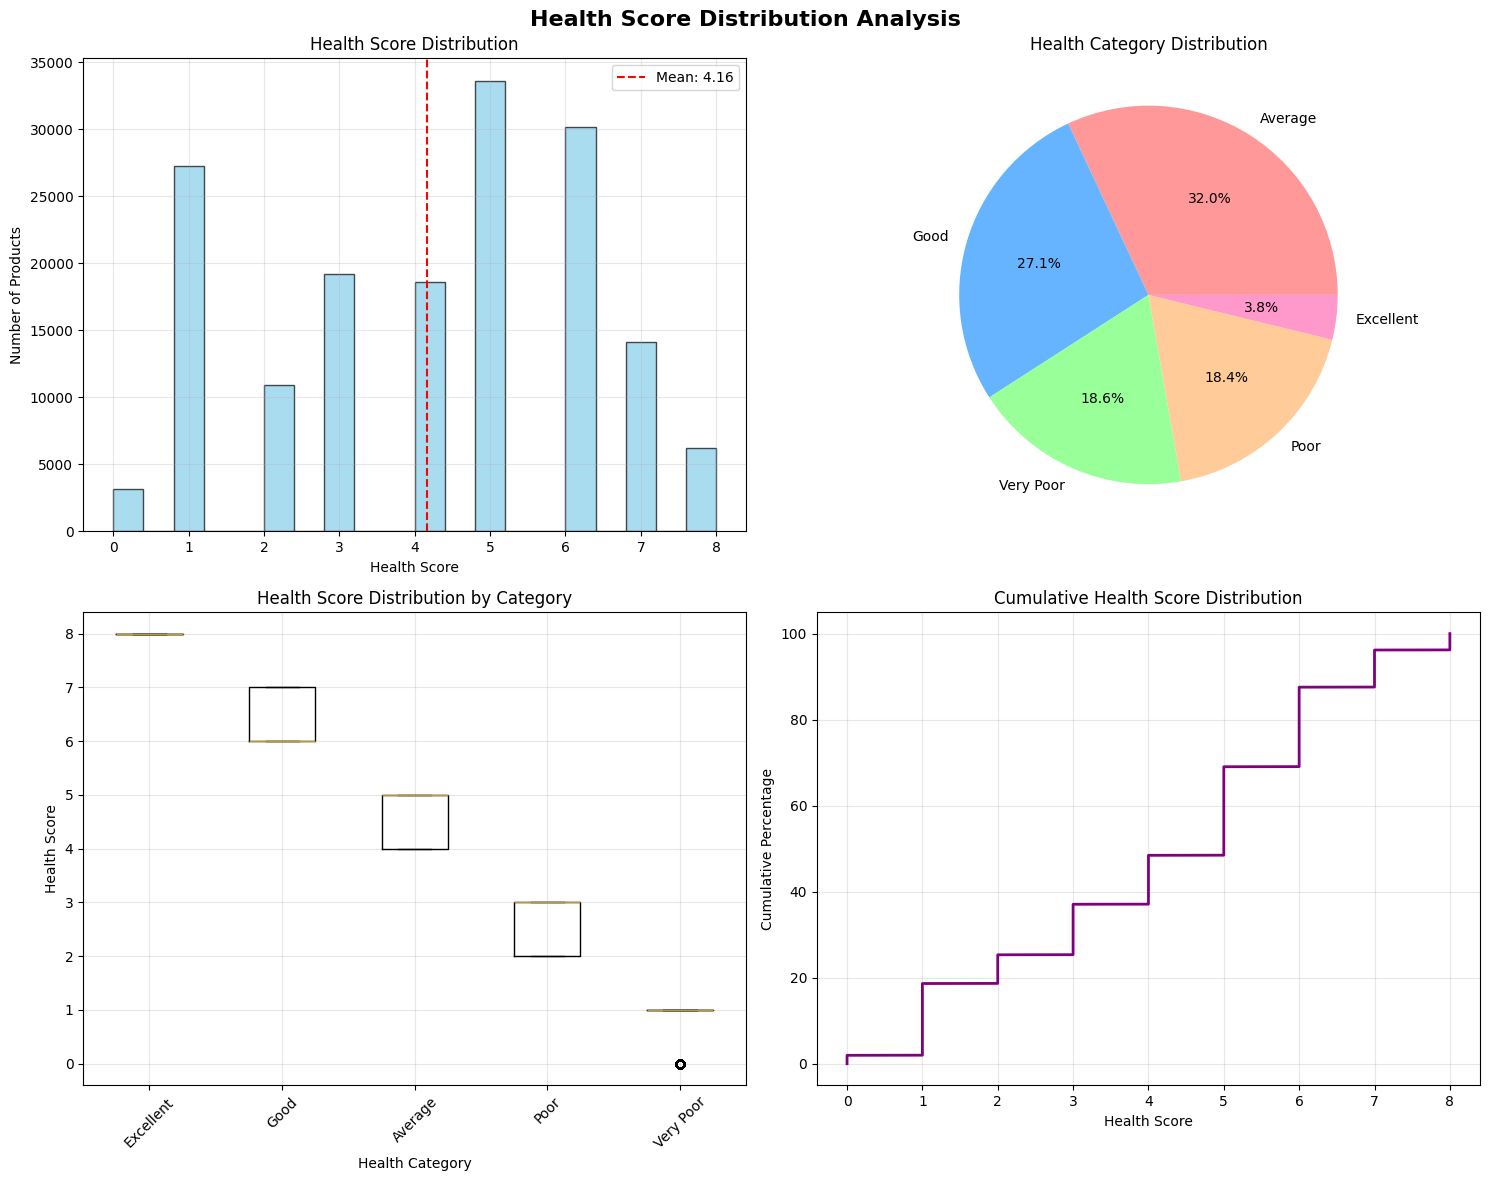

Health Category Breakdown:
+---------------+-----+----------+---------+
|health_category|count|percentage|avg_score|
+---------------+-----+----------+---------+
|      Excellent| 6231|       3.8|      8.0|
|           Good|44314|      27.1|     6.32|
|        Average|52208|      32.0|     4.64|
|           Poor|30088|      18.4|     2.64|
|      Very Poor|30453|      18.6|     0.89|
+---------------+-----+----------+---------+


🍎 HEALTH BY FOOD CATEGORY
Category Health Rankings:
+-------------+-------------+----------------+-----------+---------+------------+
|main_category|product_count|avg_health_score|avg_protein|avg_sugar|avg_calories|
+-------------+-------------+----------------+-----------+---------+------------+
|Meat         |2943         |6.11            |13.0       |1.6      |216.0       |
|Other        |98610        |4.98            |10.1       |7.4      |243.0       |
|Beverages    |1580         |4.72            |8.6        |7.2      |274.0       |
|Vegetables   |519    

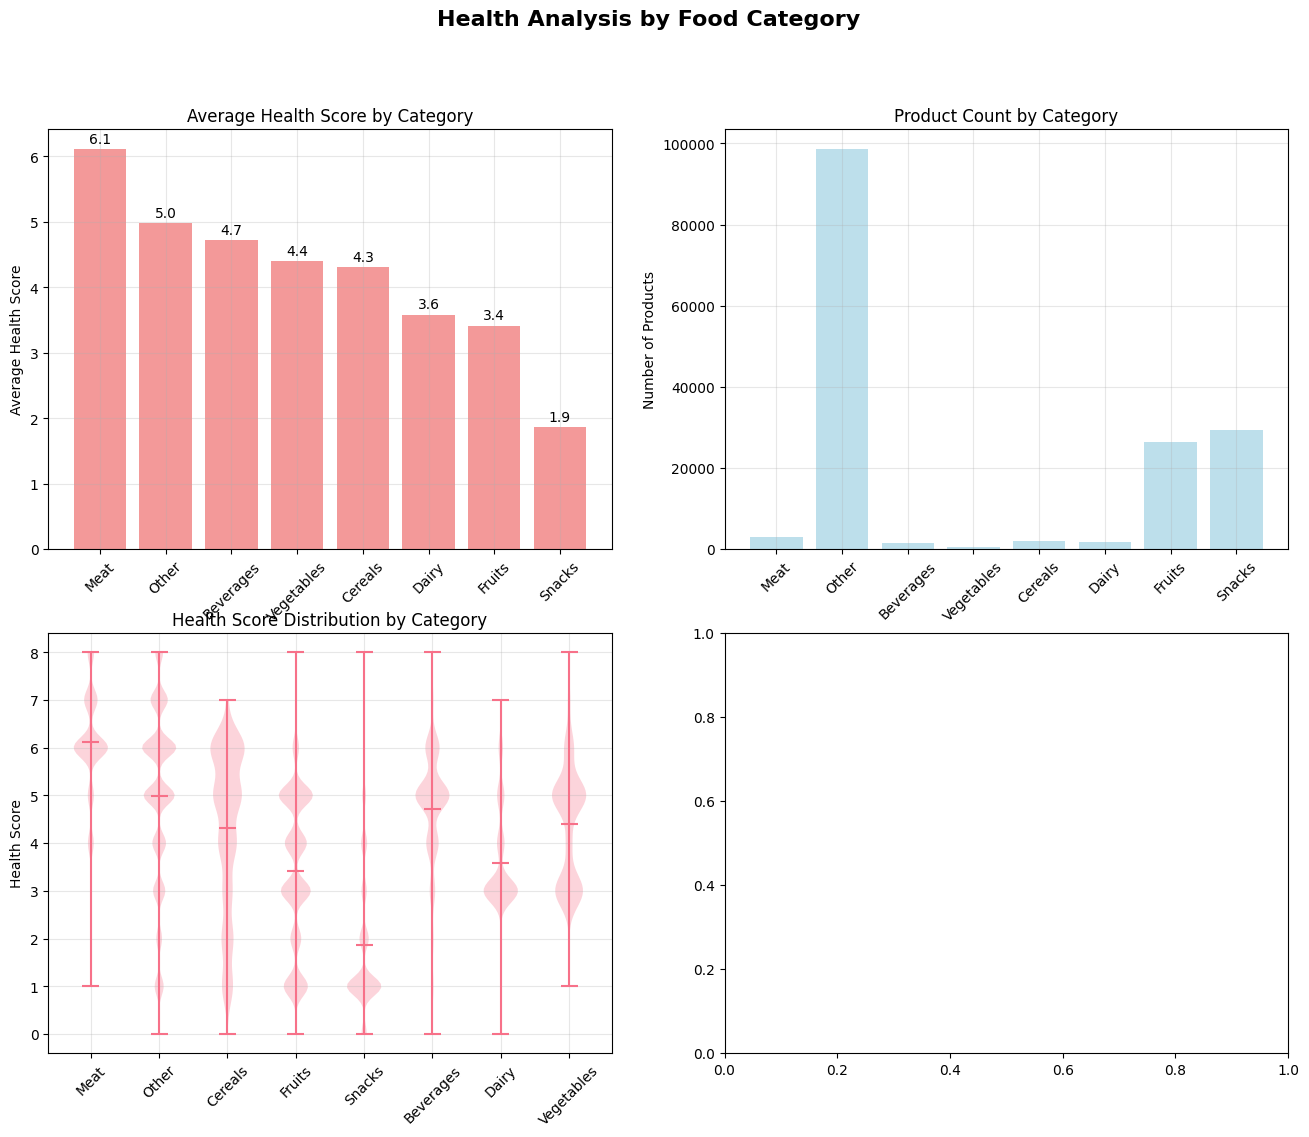

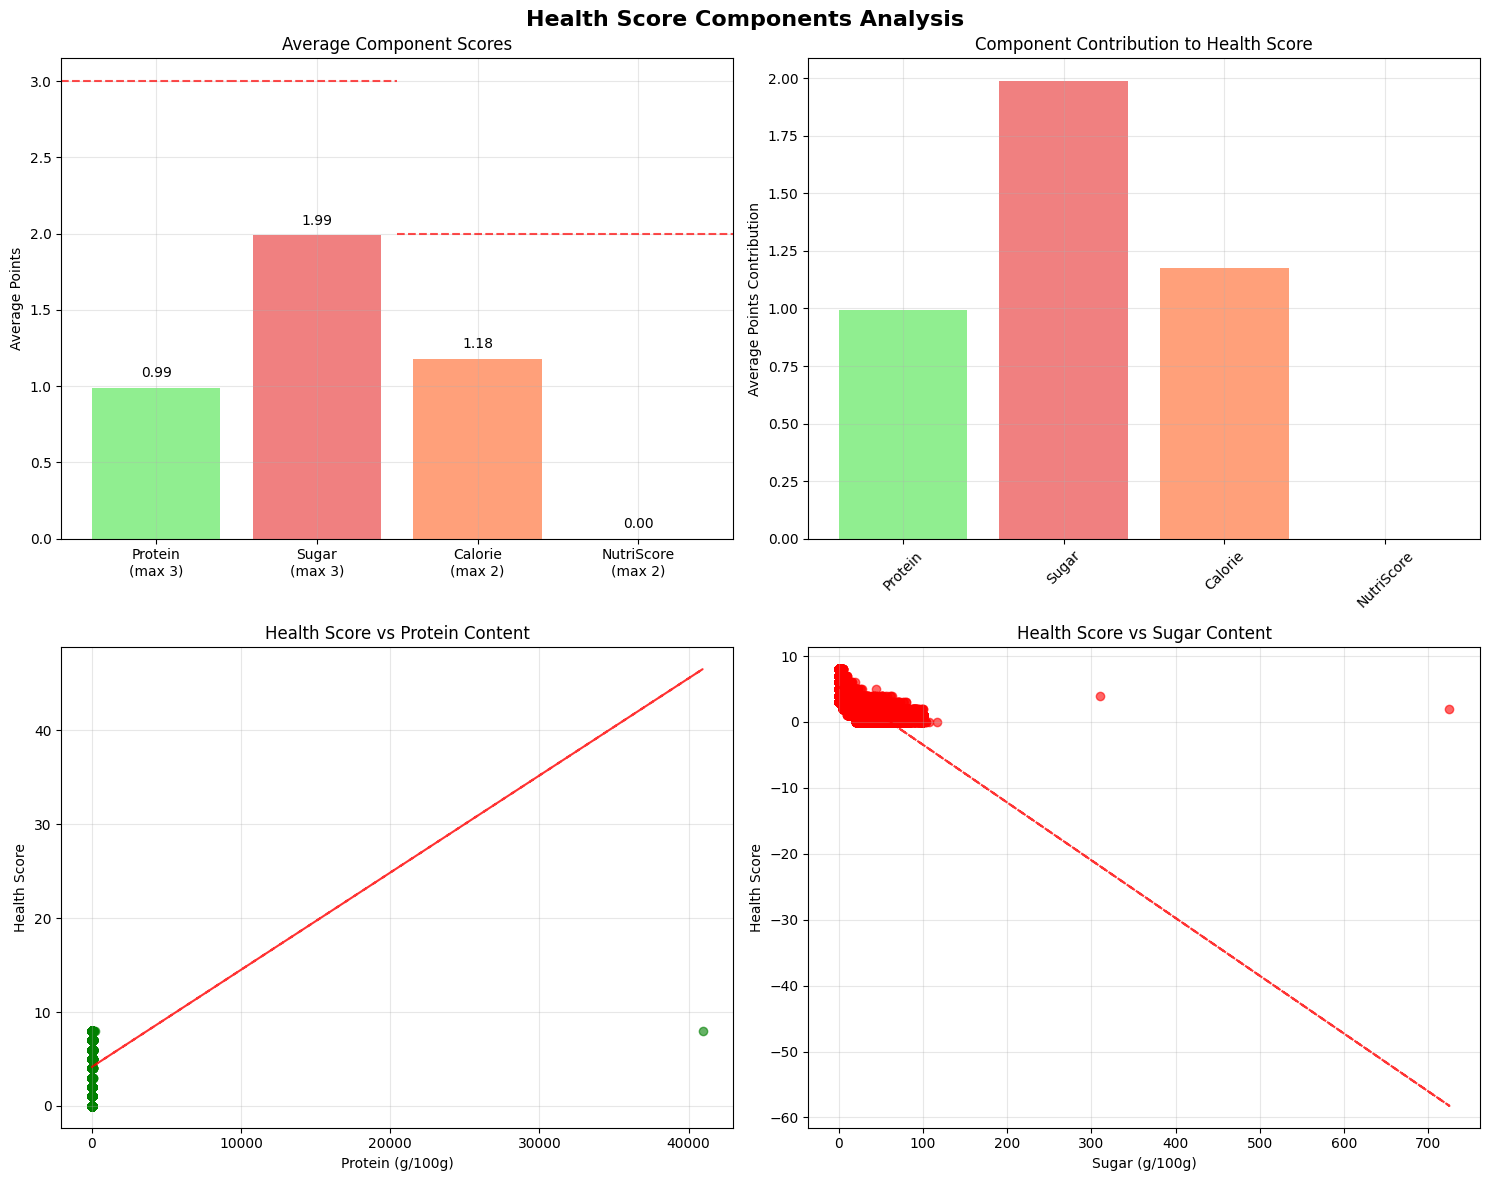

Average Points by Component (out of max possible):
Protein Component: 0.99/3.0
Sugar Component: 1.99/3.0
Calorie Component: 1.18/2.0
Nutri-Score Component: 0.0/2.0

💡 KEY INSIGHTS
 Overall health quality is AVERAGE (avg: 4.16/10)


In [38]:
# Initialize analyzer
analyzer = HealthScoreAnalyzer(spark)
results = analyzer.run_complete_analysis(final_df)

In [ ]:
final_df.show(20)

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------+----------------+------------------+-----------+-------------+--------------+-----------+------------+---------------+--------------+------------+---------------+--------------+-------------+-----------+-----------+-----------+--------------------+--------------------+
|        product_name|              brands|          categories|    ingredients_text|           allergens|nutriscore_grade|nutrition-score-fr_100g|energy-kcal_100g|carbohydrates_100g|sugars_100g|proteins_100g|has_nutriscore|brand_count|health_score|health_category|is_gluten_free|is_low_sugar|is_high_protein|is_low_calorie|is_dairy_free|is_nut_free|is_soy_free|is_egg_free|        health_flags|   allergen_friendly|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------+----------------+--

# **Recommender produit class**
 Cobined the user query and the our  data to recomand the  most matched product  also with the exicting fillters

In [39]:
class RecipeProductRecommender:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.vectorizer = None
        self.tfidf_matrix = None
        self.ingredient_vectorizer = None
        self.ingredient_tfidf_matrix = None

        # Column mapping for nutritional data
        self.nutrition_cols = {
            'calories': 'energy-kcal_100g',
            'carbs': 'carbohydrates_100g',
            'sugars': 'sugars_100g',
            'proteins': 'proteins_100g'
        }

        # Dietary restriction columns
        self.dietary_cols = {
            'gluten_free': 'is_gluten_free',
            'low_sugar': 'is_low_sugar',
            'high_protein': 'is_high_protein',
            'low_calorie': 'is_low_calorie',
            'dairy_free': 'is_dairy_free',
            'nut_free': 'is_nut_free',
            'soy_free': 'is_soy_free',
            'egg_free': 'is_egg_free'
        }

        self._prepare_data()
        self._setup_vectorizers()

    def _prepare_data(self):
        # Handle missing values for text columns
        text_cols = ['product_name', 'brands', 'categories', 'ingredients_text', 'allergens']
        for col in text_cols:
            if col in self.df.columns:
                self.df[col] = self.df[col].fillna('')

        # Create comprehensive search text
        health_flags_text = self.df.get('health_flags', pd.Series('')).fillna('').str.replace('_', ' ')
        allergen_friendly_text = self.df.get('allergen_friendly', pd.Series('')).fillna('').str.replace('_', ' ')

        self.df['search_text'] = (
            self.df.get('product_name', pd.Series('')).str.lower() + ' ' +
            self.df.get('brands', pd.Series('')).str.lower() + ' ' +
            self.df.get('categories', pd.Series('')).str.lower() + ' ' +
            self.df.get('ingredients_text', pd.Series('')).str.lower() + ' ' +
            health_flags_text.str.lower() + ' ' +
            allergen_friendly_text.str.lower()
        ).str.strip()

        # Clean ingredients text for better processing
        self.df['cleaned_ingredients'] = self.df.get('ingredients_text', pd.Series('')).fillna('').apply(self._clean_ingredient_text)

        # Calculate health score if not available
        if 'health_score' not in self.df.columns:
            self.df['health_score'] = self._calculate_health_score()

        # Clean numerical columns
        for col in self.nutrition_cols.values():
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)

        # Ensure boolean columns are properly typed
        for col in self.dietary_cols.values():
            if col in self.df.columns:
                self.df[col] = self.df[col].astype(bool)

    def _clean_ingredient_text(self, text: str) -> str:
        if not text:
            return ""
        text = re.sub(r'\b(organic|natural|fresh|dried|powdered|extract)\b', '', text.lower())
        text = re.sub(r'\([^)]*\d+[^)]*\)', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def _setup_vectorizers(self):
        valid_texts = self.df['search_text'][self.df['search_text'].str.len() > 0]

        if len(valid_texts) == 0:
            raise ValueError("No valid text data found")

        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            stop_words='english',
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.95,
            lowercase=True,
            strip_accents='unicode',
            token_pattern=r'\b[a-zA-Z][a-zA-Z0-9]*\b'
        )

        self.tfidf_matrix = self.vectorizer.fit_transform(self.df['search_text'])
        valid_ingredients = self.df['cleaned_ingredients'][self.df['cleaned_ingredients'].str.len() > 0]

        if len(valid_ingredients) > 0:
            self.ingredient_vectorizer = TfidfVectorizer(
                max_features=5000,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=1,
                max_df=0.9,
                lowercase=True,
                strip_accents='unicode'
            )

            self.ingredient_tfidf_matrix = self.ingredient_vectorizer.fit_transform(self.df['cleaned_ingredients'])

    def _calculate_health_score(self) -> pd.Series:
        score = pd.Series(5.0, index=self.df.index)
        nutri_map = {'A': 8, 'B': 6, 'C': 5, 'D': 3, 'E': 1}
        if 'nutriscore_grade' in self.df.columns:
            nutri_scores = self.df['nutriscore_grade'].map(nutri_map)
            score = score.where(nutri_scores.isna(), nutri_scores)

        # Boost score based on health flags
        if 'health_flags' in self.df.columns:
            health_flags = self.df['health_flags'].fillna('')
            positive_flags = ['low_sugar', 'high_protein', 'gluten_free', 'low_calorie']
            for flag in positive_flags:
                flag_boost = health_flags.str.contains(flag, case=False).astype(int) * 0.5
                score = np.minimum(score + flag_boost, 10)

        # Adjust based on nutritional content
        if 'sugars_100g' in self.df.columns:
            sugar_penalty = np.clip(self.df['sugars_100g'] / 15, 0, 2)
            score = np.maximum(score - sugar_penalty, 1)

        if 'proteins_100g' in self.df.columns:
            protein_boost = np.clip(self.df['proteins_100g'] / 25, 0, 2)
            score = np.minimum(score + protein_boost, 10)

        if 'energy-kcal_100g' in self.df.columns:
            calorie_penalty = np.where(self.df['energy-kcal_100g'] > 500, 1, 0)
            score = np.maximum(score - calorie_penalty, 1)

        return score.fillna(5.0)

    def recommend(self,
                 recipe_text: str = "",
                 ingredients: List[str] = None,
                 dietary_preferences: List[str] = None,
                 filters: Dict = None,
                 top_n: int = 10,
                 min_similarity: float = 0.05,
                 prioritize_health: bool = True,
                 ingredient_weight: float = 0.4) -> pd.DataFrame:

        # Build search query
        search_query = self._build_query(recipe_text, ingredients, dietary_preferences)

        # Calculate similarities
        general_similarities = self._get_general_similarities(search_query)
        ingredient_similarities = self._get_ingredient_similarities(ingredients)

        # Combine similarities
        combined_similarities = self._combine_similarities(
            general_similarities,
            ingredient_similarities,
            ingredient_weight
        )

        # Apply filters
        valid_mask = self._apply_filters(filters, dietary_preferences)
        valid_mask &= (combined_similarities >= min_similarity)

        if not valid_mask.any():
            return pd.DataFrame()

        # Calculate final scores
        final_scores = self._calculate_scores(combined_similarities, valid_mask, prioritize_health)

        # Get top results
        top_indices = final_scores.nlargest(top_n).index

        return self._format_output(top_indices, combined_similarities, final_scores, ingredients)

    def _build_query(self, recipe_text: str, ingredients: List[str] = None,
                    dietary_preferences: List[str] = None) -> str:
        parts = []

        if recipe_text:
            parts.append(recipe_text.lower().strip())

        if ingredients:
            clean_ingredients = [ing.lower().strip() for ing in ingredients if ing.strip()]
            parts.extend(clean_ingredients)

        if dietary_preferences:
            diet_terms = []
            for pref in dietary_preferences:
                if pref in self.dietary_cols:
                    diet_terms.append(pref.replace('_', ' '))
                    diet_terms.append(pref)
            parts.extend(diet_terms)

        return ' '.join(parts)

    def _get_general_similarities(self, query: str) -> pd.Series:
        if not query.strip():
            return pd.Series(0.0, index=self.df.index)

        query_vec = self.vectorizer.transform([query])
        similarities = cosine_similarity(query_vec, self.tfidf_matrix).flatten()

        return pd.Series(similarities, index=self.df.index)

    def _get_ingredient_similarities(self, ingredients: List[str] = None) -> pd.Series:
        if not ingredients or not self.ingredient_vectorizer:
            return pd.Series(0.0, index=self.df.index)

        # Clean and combine ingredients
        clean_ingredients = [self._clean_ingredient_text(ing) for ing in ingredients if ing.strip()]
        ingredient_query = ' '.join(clean_ingredients)

        if not ingredient_query.strip():
            return pd.Series(0.0, index=self.df.index)

        query_vec = self.ingredient_vectorizer.transform([ingredient_query])
        similarities = cosine_similarity(query_vec, self.ingredient_tfidf_matrix).flatten()

        return pd.Series(similarities, index=self.df.index)

    def _combine_similarities(self, general_sim: pd.Series, ingredient_sim: pd.Series,
                            ingredient_weight: float) -> pd.Series:
        general_weight = 1 - ingredient_weight

        return general_weight * general_sim + ingredient_weight * ingredient_sim

    def _apply_filters(self, filters: Dict = None, dietary_preferences: List[str] = None) -> pd.Series:
        mask = pd.Series(True, index=self.df.index)

        # Apply dietary preferences as hard filters
        if dietary_preferences:
            for pref in dietary_preferences:
                if pref in self.dietary_cols:
                    col_name = self.dietary_cols[pref]
                    if col_name in self.df.columns:
                        mask &= self.df[col_name] == True

        if not filters:
            return mask

        # Nutritional filters
        if 'max_calories' in filters and 'energy-kcal_100g' in self.df.columns:
            mask &= self.df['energy-kcal_100g'] <= filters['max_calories']

        if 'max_sugar' in filters and 'sugars_100g' in self.df.columns:
            mask &= self.df['sugars_100g'] <= filters['max_sugar']

        if 'min_protein' in filters and 'proteins_100g' in self.df.columns:
            mask &= self.df['proteins_100g'] >= filters['min_protein']

        if 'max_carbs' in filters and 'carbohydrates_100g' in self.df.columns:
            mask &= self.df['carbohydrates_100g'] <= filters['max_carbs']

        # NutriScore filter
        if 'nutriscore' in filters and 'nutriscore_grade' in self.df.columns:
            allowed = filters['nutriscore']
            if isinstance(allowed, str):
                allowed = [allowed]
            mask &= self.df['nutriscore_grade'].isin(allowed)

        # Brand filter
        if 'brands' in filters and 'brands' in self.df.columns:
            brands = filters['brands']
            if isinstance(brands, str):
                brands = [brands]
            brand_mask = pd.Series(False, index=self.df.index)
            for brand in brands:
                brand_mask |= self.df['brands'].str.contains(brand, case=False, na=False)
            mask &= brand_mask

        return mask

    def _calculate_scores(self, similarities: pd.Series, valid_mask: pd.Series,
                        prioritize_health: bool = True) -> pd.Series:
        """Calculate final ranking scores."""
        scores = pd.Series(0.0, index=self.df.index)

        if not valid_mask.any():
            return scores

        valid_sim = similarities[valid_mask]
        valid_health = self.df.loc[valid_mask, 'health_score']

        # Normalize scores
        if valid_sim.max() > 0:
            norm_sim = valid_sim / valid_sim.max()
        else:
            norm_sim = pd.Series(0.0, index=valid_sim.index)

        norm_health = valid_health / 10.0

        # Calculate weighted scores
        if prioritize_health:
            scores[valid_mask] = 0.55 * norm_sim + 0.45 * norm_health
        else:
            scores[valid_mask] = 0.70 * norm_sim + 0.30 * norm_health

        return scores

    def _format_output(self, indices: pd.Index, similarities: pd.Series,
                      final_scores: pd.Series, matched_ingredients: List[str] = None) -> pd.DataFrame:
        """Format results with ingredient matching information."""
        if len(indices) == 0:
            return pd.DataFrame()

        result = self.df.loc[indices].copy()
        result['similarity_score'] = similarities.loc[indices].round(3)
        result['final_score'] = final_scores.loc[indices].round(3)

        # Add ingredient matching information
        if matched_ingredients:
            result['matched_ingredients'] = result['ingredients_text'].apply(
                lambda x: self._count_ingredient_matches(x, matched_ingredients)
            )

        # Select display columns
        display_cols = ['product_name', 'brands', 'final_score', 'similarity_score', 'health_score']

        if matched_ingredients:
            display_cols.append('matched_ingredients')

        # Add available columns
        optional_cols = ['nutriscore_grade', 'health_category', 'energy-kcal_100g',
                        'proteins_100g', 'sugars_100g', 'categories', 'ingredients_text']

        for col in optional_cols:
            if col in result.columns:
                display_cols.append(col)

        # Filter existing columns
        final_cols = [col for col in display_cols if col in result.columns]

        return result[final_cols].reset_index(drop=True)

    def _count_ingredient_matches(self, product_ingredients: str, search_ingredients: List[str]) -> int:

        if not product_ingredients or not search_ingredients:
            return 0

        product_lower = product_ingredients.lower()
        matches = 0

        for ingredient in search_ingredients:
            if ingredient.lower().strip() in product_lower:
                matches += 1

        return matches

    def get_ingredient_suggestions(self, partial: str, limit: int = 10) -> List[str]:
        if not partial or len(partial) < 2:
            return []

        all_ingredients = set()
        partial_lower = partial.lower()

        for ing_text in self.df['ingredients_text'].dropna():
            # Split by common separators
            ingredients = re.split(r'[,;()]\s*', ing_text.lower())
            for ing in ingredients:
                ing = ing.strip()
                if len(ing) > 2 and partial_lower in ing:
                    # Clean the ingredient suggestion
                    clean_ing = re.sub(r'\([^)]*\)', '', ing).strip()
                    if clean_ing:
                        all_ingredients.add(clean_ing)

        return sorted(all_ingredients, key=len)[:limit]

    def search_by_ingredients_only(self, ingredients: List[str], top_n: int = 10) -> pd.DataFrame:
        if not ingredients:
            return pd.DataFrame()

        return self.recommend(
            recipe_text="",
            ingredients=ingredients,
            top_n=top_n,
            ingredient_weight=0.8,
            prioritize_health=False
        )

    def get_dietary_options(self) -> Dict[str, int]:
        options = {}
        for diet_name, col_name in self.dietary_cols.items():
            if col_name in self.df.columns:
                count = self.df[col_name].sum()
                options[diet_name] = int(count)
        return options

    def get_nutrition_summary(self, product_indices: List[int] = None) -> Dict:
        if product_indices:
            subset = self.df.iloc[product_indices]
        else:
            subset = self.df

        summary = {}
        for col in self.nutrition_cols.values():
            if col in subset.columns:
                col_data = subset[col].dropna()
                if len(col_data) > 0:
                    summary[col] = {
                        'mean': builtins.round(col_data.mean(), 2),
                        'median': builtins.round(col_data.median(), 2),
                        'min': col_data.min(),
                        'max': col_data.max(),
                        'count': len(col_data)
                    }
        return summary



In [ ]:
pandas_final_df = final_df.toPandas()
recomender = RecipeProductRecommender(pandas_final_df)
joblib.dump(recomender, 'recipe_recommender.pkl')


['recipe_recommender.pkl']

**Exemple**

In [ ]:
results = recommender.recommend(
    recipe_text="italian pasta",
    ingredients=["cheese", "pasta", "tomato sause"],
    dietary_preferences=["gluten_free"],

    top_n=5
)
print(results)

                         product_name        brands  final_score  \
0    Ditalini Sans Gluten Mais Et Riz  Nature & Cie        0.775   
1                     cochinita pibil         Chata        0.760   
2                        Penne Rigate         Rummo        0.729   
3                                Pâte     Pasta Pro        0.724   
4  Di Bologna - Bolognese Pasta Sauce      Classico        0.647   

   similarity_score  health_score  matched_ingredients nutriscore_grade  \
0             0.542           5.0                    1                C   
1             0.439           7.0                    1                D   
2             0.452           6.0                    1                A   
3             0.447           6.0                    1                B   
4             0.460           4.0                    0                C   

  health_category  energy-kcal_100g  proteins_100g  sugars_100g  \
0         Average             364.0            6.8          0.0   
1     

**Exemple 2**

In [ ]:
salad_results = recommender.recommend(
    recipe_text="fresh salad bowl",
    ingredients=[
        "chicken breast",
        "quinoa",
        "spinach",
        "avocado",
        "chickpeas",
        "feta cheese",
        "olive oil",
        "lemon"
    ],
    dietary_preferences=["high_protein"],
    filters={
        'min_protein': 15,
        'max_calories': 300,
        'categories': ['salads', 'ready meals', 'protein']
    },
    top_n=8,
    prioritize_health=True,
    ingredient_weight=0.5
)
print(salad_results)


                            product_name        brands  final_score  \
0                            Feta cheese       Athenos        0.820   
1            Feta authentic greek cheese        Mevgal        0.810   
2                        BUCKET TENDERS®           KFC        0.766   
3     British Butter Roast Chicken Breat          Asda        0.759   
4  Small Trouts - Extra Virgin Olive Oil       AuDouce        0.729   
5                        Paté de Sardine    La Gondola        0.684   
6                   Roast Chicken Pieces       unknown        0.676   
7            Sweet apple chicken sausage  Trader Joe's        0.647   

   similarity_score  health_score  matched_ingredients nutriscore_grade  \
0             0.370           6.0                    1                E   
1             0.363           6.0                    1                E   
2             0.303           7.0                    0                D   
3             0.269           8.0                    1      